In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_ta as ta
import seaborn as sns

/home/sukrit/miniconda3/envs/trading-analysis/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# ฟังก์ชันตรวจจับ Drip และบันทึก RSI ที่จุดต่ำสุด
def detect_drip_with_rsi_at_low(data, window=12, threshold=-0.05):
    drips = []
    for i in range(len(data) - window):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            # หา index และเวลาของ Low
            low_idx = data['low'].iloc[i:i+window].idxmin()
            rsi_at_low = data['RSI_14'].loc[low_idx] if low_idx in data.index else np.nan
            drips.append({
                'start_time': data.index[i],
                'low_time': low_idx,
                'close_price': close_price,
                'low_price': low_price,
                'drip_pct': drip_pct * 100,
                'rsi_at_low': rsi_at_low,
                'month': data.index[i].month
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/1/BTCUSDT.pkl"))
data['RSI_14'] = ta.rsi(data['close'], length=14)

# ตรวจจับ Drip และบันทึก RSI
drips = detect_drip_with_rsi_at_low(data)

In [4]:
# 1. การแจกแจงของ RSI ที่จุดต่ำสุดของ Drip
print("\nSummary of RSI at Drip Low:")
rsi_summary = {
    'Number of Drips': len(drips),
    'Mean RSI': drips['rsi_at_low'].mean(),
    'Std RSI': drips['rsi_at_low'].std(),
    'Min RSI': drips['rsi_at_low'].min(),
    'Max RSI': drips['rsi_at_low'].max(),
    'Median RSI': drips['rsi_at_low'].median()
}
for key, value in rsi_summary.items():
  print(f"{key}: {value:.2f}")


Summary of RSI at Drip Low:
Number of Drips: 101.00
Mean RSI: 21.69
Std RSI: 16.69
Min RSI: 2.66
Max RSI: 83.39
Median RSI: 17.37


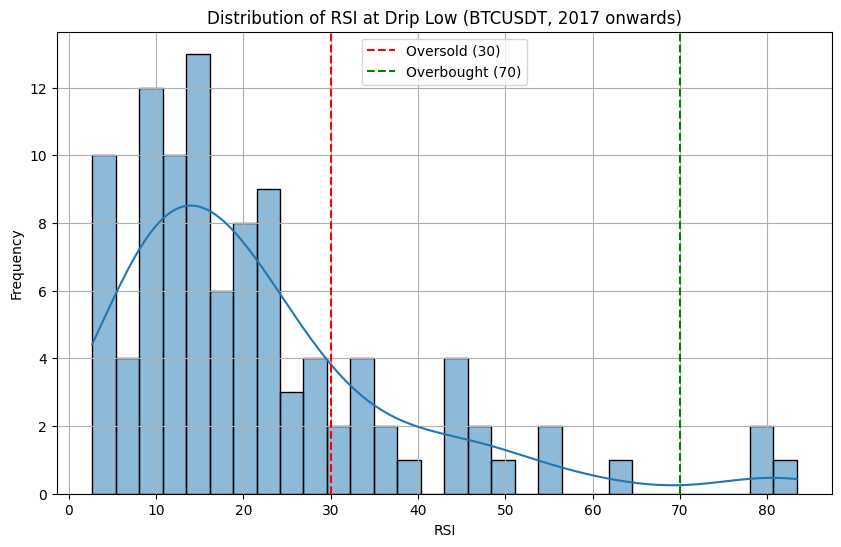

In [5]:
# สร้างฮิสโตแกรมของ RSI
plt.figure(figsize=(10, 6))
sns.histplot(drips['rsi_at_low'].dropna(), bins=30, kde=True)
plt.title('Distribution of RSI at Drip Low (BTCUSDT, 2017 onwards)')
plt.xlabel('RSI')
plt.ylabel('Frequency')
plt.axvline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axvline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# ทดสอบความปกติของ RSI (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(drips['rsi_at_low'].dropna())
print(f"\nShapiro-Wilk Test for RSI Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("RSI distribution is not normal (p < 0.05)")
else:
    print("RSI distribution is normal (p >= 0.05)")


Shapiro-Wilk Test for RSI Normality: stat=0.8387, p-value=0.0000
RSI distribution is not normal (p < 0.05)


In [7]:
# 2. ค่าเฉลี่ย RSI ตามเดือน
monthly_rsi_means = drips.groupby('month')['rsi_at_low'].mean().reset_index()
monthly_rsi_means.columns = ['Month', 'Mean RSI']
print("\nMean RSI at Drip Low by Month:")
print(monthly_rsi_means.round(2))


Mean RSI at Drip Low by Month:
    Month  Mean RSI
0       1     27.34
1       2     31.24
2       3     20.49
3       4     14.05
4       5     14.30
5       6     11.00
6       7     49.81
7       8      8.17
8       9     23.54
9      10     29.24
10     11     23.61
11     12     19.99


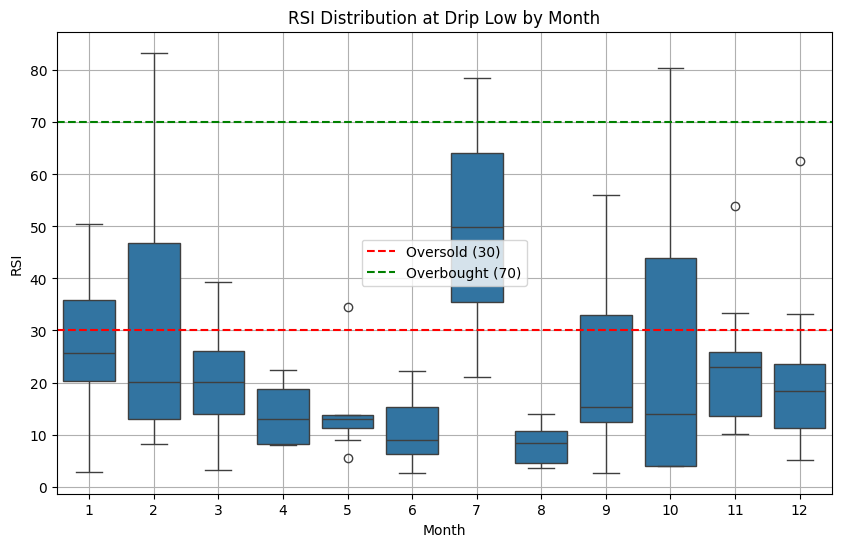

In [8]:
# สร้าง Boxplot เพื่อแสดงการกระจายของ RSI ตามเดือน
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='rsi_at_low', data=drips)
plt.title('RSI Distribution at Drip Low by Month')
plt.xlabel('Month')
plt.ylabel('RSI')
plt.axhline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axhline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 3. One-Way ANOVA Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['rsi_at_low'].dropna() for month in drips['month'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nOne-Way ANOVA Test for RSI: F={f_stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Significant difference in mean RSI between months (p < 0.05)")
    else:
        print("No significant difference in mean RSI between months (p >= 0.05)")
else:
    print("\nANOVA Test: Not enough months to perform the test.")


One-Way ANOVA Test for RSI: F=2.1296, p-value=0.0259
Significant difference in mean RSI between months (p < 0.05)


In [10]:
# 4. T-Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างคู่เดือน
print("\nT-Test Results for RSI (p-values for pairwise comparisons):")
t_test_results = []
month_pairs = list(itertools.combinations(drips['month'].unique(), 2))
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['rsi_at_low'].dropna()
    group2 = drips[drips['month'] == month2]['rsi_at_low'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results for RSI (p-values for pairwise comparisons):
   Month Pair  T-Statistic  P-Value
0      8 vs 9      -1.8991   0.0841
1     8 vs 10      -1.5663   0.1517
2     8 vs 11      -2.6748   0.0191
3     8 vs 12      -2.2817   0.0313
4      8 vs 1      -3.5174   0.0022
..        ...          ...      ...
61     5 vs 3      -1.2138   0.2449
62     5 vs 7      -2.7199   0.0263
63     6 vs 3      -1.8814   0.0825
64     6 vs 7      -2.8946   0.0232
65     3 vs 7      -2.0588   0.0735

[66 rows x 3 columns]


In [11]:
# 5. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['rsi_at_low'].dropna(), groups=drips['month'], alpha=0.05)
    print("\nTukey’s HSD Test Results for RSI:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough months to perform the test.")


Tukey’s HSD Test Results for RSI:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   3.8983    1.0 -18.9735 26.7701  False
     1      3  -6.8426 0.9972 -29.7145 16.0292  False
     1      4 -13.2841 0.9339 -42.8115 16.2433  False
     1      5 -13.0402 0.7475  -35.912  9.8317  False
     1      6 -16.3324 0.4911 -40.2686  7.6038  False
     1      7  22.4691 0.7536  -17.146 62.0843  False
     1      8 -19.1646 0.3274 -44.4504  6.1211  False
     1      9  -3.7955    1.0 -27.7317 20.1407  False
     1     10   1.8989    1.0 -25.1634 28.9612  False
     1     11  -3.7243    1.0 -25.7327 18.2841  False
     1     12  -7.3505 0.9591 -24.8785 10.1774  False
     2      3 -10.7409 0.9671  -37.151 15.6692  False
     2      4 -17.1824 0.8226 -49.5281 15.1632  False
     2      5 -16.9385 0.5872 -43.3486  9.4717  False
     2      6 -20.2307 0.3635 -47.5678  7.1064 

In [12]:
# 6. F-Test: เปรียบเทียบความแปรปรวน RSI ระหว่างคู่เดือน
print("\nF-Test Results for RSI Variance:")
f_test_results = []
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['rsi_at_low'].dropna()
    group2 = drips[drips['month'] == month2]['rsi_at_low'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        f_stat = var1 / var2 if var1 > var2 else var2 / var1
        df1, df2 = len(group1) - 1, len(group2) - 1
        p_value = 1 - stats.f.cdf(f_stat, df1, df2)
        f_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'F-Statistic': f_stat,
            'P-Value': p_value
        })
f_test_df = pd.DataFrame(f_test_results)
print(f_test_df.round(4))


F-Test Results for RSI Variance:
   Month Pair  F-Statistic  P-Value
0      8 vs 9      21.5487   0.0009
1     8 vs 10      62.7765   0.0007
2     8 vs 11      10.6218   0.0022
3     8 vs 12       8.7733   0.0002
4      8 vs 1       9.6323   0.0003
..        ...          ...      ...
61     5 vs 3       1.7883   0.2305
62     5 vs 7      22.1686   0.1621
63     6 vs 3       2.6890   0.1108
64     6 vs 7      33.3338   0.1318
65     3 vs 7      12.3965   0.2154

[66 rows x 3 columns]


In [13]:
# 7. Levene’s Test: เปรียบเทียบความแปรปรวน RSI ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    groups = [drips[drips['month'] == month]['rsi_at_low'].dropna() for month in drips['month'].unique()]
    stat, p_value = stats.levene(*groups)
    print(f"\nLevene’s Test for RSI Variance: stat={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("Variances are significantly different (p < 0.05)")
    else:
        print("No significant difference in variances (p >= 0.05)")
else:
    print("\nLevene’s Test: Not enough months to perform the test.")


Levene’s Test for RSI Variance: stat=2.2767, p-value=0.0168
Variances are significantly different (p < 0.05)
